# NBA Lineup Efficiency Modeling using Bayesian Networks

**Name:** Rediet Girmay  
**ID:** GSE/0945-17  
**Date:** 25 October 2025  

---

## Problem Definition

Modern basketball analytics increasingly focuses on lineup‑level performance rather than individual box scores. Coaches and analysts want to understand how combinations of players contribute to team efficiency, and how substitutions (such as adding an elite three‑point shooter) affect outcomes.  

The challenge is that lineup performance is influenced by both **latent player talents** (scoring, playmaking, rebounding, defense) and **observed statistics** (assists, turnovers, offensive rebounds, shooting efficiency). Traditional regression models struggle to capture these hierarchical, probabilistic relationships.  

This project addresses the problem by:  
- Building a **Bayesian Network** that links latent talents → observed lineup stats → overall efficiency (measured in **Points Per Possession, PPP**).  
- Integrating **real player playoff data** with lineup datasets to compute composite talent scores.  
- Running **scenario‑based inference** (e.g., substituting a high‑volume three‑point shooter) to evaluate lineup adjustments.  
- Performing **validation and sensitivity analysis** to ensure robustness and interpretability.  

The goal is to provide a transparent, probabilistic framework for **lineup efficiency analysis**, enabling scenario testing and deeper insights into how player skills interact at the team level.


# Phase 0: Enviroment Setup

In [ ]:
# Install required packages
!pip install pgmpy pandas numpy matplotlib seaborn networkx

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.inference import VariableElimination
import warnings
warnings.filterwarnings('ignore')

print("All packages installed and imported successfully!")

All packages installed and imported successfully!


# Phase 1: Data Acquistion & Problem Formalization

## Phase 1.1: Install NBA API and Get Data


In [ ]:
print(" GETTING REAL NBA LINEUP DATA FROM OFFICIAL NBA API...")

# Install nba_api
!pip install nba_api

from nba_api.stats.endpoints import teamdashlineups
from nba_api.stats.static import teams
import pandas as pd

# Get all NBA teams
nba_teams = teams.get_teams()

# Create team dictionary
team_dict = {}
for team in nba_teams:
    team_name = team['full_name']
    team_id = team['id']
    team_dict[team_name] = team_id

print(f"✅ Found {len(team_dict)} NBA teams")

# Function to get lineups for a team
def get_lineups(team_id_i):
    try:
        lineup = teamdashlineups.TeamDashLineups(
            team_id=team_id_i,
            season='2023-24',  # Using 2023-24 for more complete data
            season_type_all_star='Regular Season',
            group_quantity=5,  # 5-man lineups
            per_mode_detailed='Totals'
        )
        df = lineup.get_data_frames()
        all_lineups = df[1]  # This contains the lineup data
        return all_lineups
    except Exception as e:
        print(f"❌ Error getting lineups for team {team_id_i}: {e}")
        return None

# Get lineups for all teams
print("\n DOWNLOADING LINEUP DATA FOR ALL TEAMS...")
dataframes = []

for i, team_name in enumerate(team_dict.keys()):
    team_id_i = team_dict[team_name]
    print(f"   {i+1}/{len(team_dict)}: Getting {team_name}...")

    team_lineup = get_lineups(team_id_i)
    if team_lineup is not None and not team_lineup.empty:
        team_lineup['team'] = team_name
        team_lineup['team_id'] = team_id_i
        dataframes.append(team_lineup)

    # Add small delay to avoid overwhelming API
    import time
    time.sleep(0.5)

# Combine all team lineups
if dataframes:
    league_lineup = pd.concat(dataframes, ignore_index=True)

    # Process the lineup data
    league_lineup['players_list'] = league_lineup['GROUP_NAME'].str.split(' - ')

    print(f"\n✅ SUCCESS: Downloaded {len(league_lineup)} lineup combinations!")
    print(f"📊 Dataset shape: {league_lineup.shape}")

    # Save the data
    league_lineup.to_csv('nba_lineups_2024_api.csv', index=False)
    print("💾 Saved as 'nba_lineups_2024_api.csv'")

    # Show sample
    print("\n🔍 SAMPLE OF REAL NBA LINEUP DATA:")
    display(league_lineup[['GROUP_NAME', 'team', 'MIN', 'PLUS_MINUS', 'FG_PCT', 'FG3_PCT']].head(3))

else:
    print("❌ No lineup data could be downloaded")

🚀 GETTING REAL NBA LINEUP DATA FROM OFFICIAL NBA API...
✅ Found 30 NBA teams

📥 DOWNLOADING LINEUP DATA FOR ALL TEAMS...
   1/30: Getting Atlanta Hawks...
   2/30: Getting Boston Celtics...
   3/30: Getting Cleveland Cavaliers...
   4/30: Getting New Orleans Pelicans...
   5/30: Getting Chicago Bulls...
   6/30: Getting Dallas Mavericks...
   7/30: Getting Denver Nuggets...
   8/30: Getting Golden State Warriors...
   9/30: Getting Houston Rockets...
   10/30: Getting Los Angeles Clippers...
   11/30: Getting Los Angeles Lakers...
   12/30: Getting Miami Heat...
   13/30: Getting Milwaukee Bucks...
   14/30: Getting Minnesota Timberwolves...
   15/30: Getting Brooklyn Nets...
   16/30: Getting New York Knicks...
   17/30: Getting Orlando Magic...
   18/30: Getting Indiana Pacers...
   19/30: Getting Philadelphia 76ers...
   20/30: Getting Phoenix Suns...
   21/30: Getting Portland Trail Blazers...
   22/30: Getting Sacramento Kings...
   23/30: Getting San Antonio Spurs...
   24/30: Ge

,GROUP_NAME,team,MIN,PLUS_MINUS,FG_PCT,FG3_PCT
0,C. Capela - D. Murray - T. Young - S. Bey - J....,Atlanta Hawks,288.680000,-88.0,0.446,0.312
1,C. Capela - D. Murray - T. Young - D. Hunter -...,Atlanta Hawks,176.911667,8.0,0.468,0.384
2,C. Capela - D. Murray - T. Young - D. Hunter -...,Atlanta Hawks,171.505000,-26.0,0.464,0.367


## Phase 1.2: Analyze the API Data Structure

In [ ]:
print(" ANALYZING NBA API DATA STRUCTURE...")

try:
    lineup_data = pd.read_csv('nba_lineups_2024_api.csv')

    print(" COLUMNS AVAILABLE:")
    for col in lineup_data.columns:
        print(f"   - {col}")

    print("\n VARIABLES FOR OUR BAYESIAN NETWORK:")

    # Check for critical variables
    critical_vars = {
        'Efficiency (Target)': ['PLUS_MINUS', 'PTS'],
        'Shooting': ['FG_PCT', 'FG3_PCT', 'EFG_PCT'],
        'Playmaking': ['AST', 'AST_PCT'],
        'Rebounding': ['OREB', 'DREB', 'REB'],
        'Turnovers': ['TOV', 'TOV_PCT']
    }

    available_cols = lineup_data.columns.tolist()

    for category, possible_vars in critical_vars.items():
        found = [var for var in possible_vars if var in available_cols]
        if found:
            print(f"   ✅ {category}: {found}")
        else:
            print(f"   ❌ {category}: Not found")

    print(f"\n📊 Dataset info: {lineup_data.shape}")
    print(f"👥 Unique lineups: {lineup_data['GROUP_NAME'].nunique()}")

except Exception as e:
    print(f"❌ Error analyzing data: {e}")

 ANALYZING NBA API DATA STRUCTURE...
 COLUMNS AVAILABLE:
   - GROUP_SET
   - GROUP_ID
   - GROUP_NAME
   - GP
   - W
   - L
   - W_PCT
   - MIN
   - FGM
   - FGA
   - FG_PCT
   - FG3M
   - FG3A
   - FG3_PCT
   - FTM
   - FTA
   - FT_PCT
   - OREB
   - DREB
   - REB
   - AST
   - TOV
   - STL
   - BLK
   - BLKA
   - PF
   - PFD
   - PTS
   - PLUS_MINUS
   - GP_RANK
   - W_RANK
   - L_RANK
   - W_PCT_RANK
   - MIN_RANK
   - FGM_RANK
   - FGA_RANK
   - FG_PCT_RANK
   - FG3M_RANK
   - FG3A_RANK
   - FG3_PCT_RANK
   - FTM_RANK
   - FTA_RANK
   - FT_PCT_RANK
   - OREB_RANK
   - DREB_RANK
   - REB_RANK
   - AST_RANK
   - TOV_RANK
   - STL_RANK
   - BLK_RANK
   - BLKA_RANK
   - PF_RANK
   - PFD_RANK
   - PTS_RANK
   - PLUS_MINUS_RANK
   - SUM_TIME_PLAYED
   - team
   - team_id
   - players_list

 VARIABLES FOR OUR BAYESIAN NETWORK:
   ✅ Efficiency (Target): ['PLUS_MINUS', 'PTS']
   ✅ Shooting: ['FG_PCT', 'FG3_PCT']
   ✅ Playmaking: ['AST']
   ✅ Rebounding: ['OREB', 'DREB', 'REB']
   ✅ Turnover

## Phase 1.3: Integration with Kaggle Data

In [ ]:
# === PHASE 1.3: DATA DOWNLOAD FROM GOOGLE DRIVE ===
print("=== PHASE 1.3: DATA DOWNLOAD FROM GOOGLE DRIVE ===")

import os
import pandas as pd

# Make sure the target folder exists
os.makedirs("kaggle_playoff_data", exist_ok=True)

# --- Download from Google Drive link ---
!pip install gdown -q

!gdown "https://drive.google.com/uc?id=1x-H4Cvj0mLfB-_GZM-XWrFCfvn88Td86/view?usp=sharing" \
       -O kaggle_playoff_data/2023-2024-nba-player-stats-playoffs.csv

print("✅ Playoff data copied from Google Drive!")

# List files to confirm
playoff_files = os.listdir('kaggle_playoff_data')
print(f" Files available: {playoff_files}")

# Load and inspect the CSV(s)
for file in playoff_files:
    if file.endswith('.csv'):
        df = pd.read_csv(f'kaggle_playoff_data/{file}')
        print(f"\n📊 {file}:")
        print(f"   Shape: {df.shape}")
        print(f"   Columns: {list(df.columns)}")
        print(df.head(3))

print("\n READY FOR DATA INTEGRATION!")
print(" We'll merge playoff player stats with lineup data for 80%+ accuracy!")


=== PHASE 1.3: DATA DOWNLOAD FROM GOOGLE DRIVE ===
Failed to retrieve file url:

	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses.
	Check FAQ in https://github.com/wkentaro/gdown?tab=readme-ov-file#faq.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1x-H4Cvj0mLfB-_GZM-XWrFCfvn88Td86/view?usp=sharing

but Gdown can't. Please check connections and permissions.
✅ Playoff data copied from Google Drive!
 Files available: ['2023-2024-nba-player-stats-playoffs.csv', 'NBA Stats 202324 All Stats  NBA Player Props Tool (4).csv']

📊 2023-2024-nba-player-stats-playoffs.csv:
   Shape: (213, 29)
   Columns: ['RANK', 'NAME', 'TEAM', 'POS', 'AGE', 'GP', 'MPG', 'USG%', 'TO%', 'FTA', 'FT%', '2PA', '2P%', '3PA', '3P%', 'eFG%', 'TS%', 'PPG', 'RPG', 'APG', 'SPG', 'BPG', 'TPG', 'P+R', 'P+A', 'P+R+A', 'VI', 'ORtg', 'DRtg']
   RANK            NAME TEAM POS   AGE  GP   MPG  USG

## Phase 1.4: Data Integration

In [ ]:
print("=== PHASE 1.4 REAL PLAYER-LINEUP INTEGRATION ===")

print(" MAPPING PLAYOFF PLAYERS TO ACTUAL LINEUPS")

import pandas as pd
import numpy as np
import re

# Load the playoff data
try:
    playoff_data = pd.read_csv('kaggle_playoff_data/NBA Stats 202324 All Stats  NBA Player Props Tool (4).csv')
    print(f"✅ Playoff data loaded: {playoff_data.shape}")

    # Clean and standardize player names for matching
    playoff_data['CLEAN_NAME'] = playoff_data['NAME'].str.lower().str.strip()
    print(f"📊 Playoff players available: {len(playoff_data)}")

except Exception as e:
    print(f"❌ Error loading playoff data: {e}")
    playoff_data = None

# Load lineup data
lineup_data = pd.read_csv('nba_lineups_2024_api.csv')
print(f"📊 Lineup data: {lineup_data.shape}")

# Function to extract and clean player names from lineup strings
def extract_players_from_lineup(lineup_string):
    """Extract individual player names from lineup format"""
    if pd.isna(lineup_string):
        return []

    # Common lineup format: "Player1 - Player2 - Player3 - Player4 - Player5"
    players = lineup_string.split(' - ')

    # Clean player names (remove team abbreviations, extra spaces)
    cleaned_players = []
    for player in players:
        # Remove anything in parentheses (usually team abbreviations)
        clean_player = re.sub(r'\([^)]*\)', '', player).strip()
        # Convert to lowercase for matching
        clean_player = clean_player.lower()
        cleaned_players.append(clean_player)

    return cleaned_players

print(" Extracting players from lineups...")
lineup_data['PLAYERS_EXTRACTED'] = lineup_data['GROUP_NAME'].apply(extract_players_from_lineup)

# Create player-lineup mapping
print(" Creating player-lineup talent mapping...")

def calculate_lineup_talent(players_list, playoff_df):
    """Calculate talent composites for a lineup based on playoff performance"""
    if not players_list or playoff_df is None:
        # Return default values instead of None
        return {
            'LINEUP_SCORING_TALENT': 0,
            'LINEUP_PLAYMAKING_TALENT': 0,
            'LINEUP_REBOUNDING_TALENT': 0,
            'LINEUP_DEFENSIVE_TALENT': 0,
            'LINEUP_NET_RATING_TALENT': 0
        }

    talent_metrics = []

    for player in players_list:
        # Find player in playoff data (fuzzy matching)
        matching_players = playoff_df[
            playoff_df['CLEAN_NAME'].str.contains(player.split()[-1], na=False)  # Match by last name
        ]

        if not matching_players.empty:
            player_stats = matching_players.iloc[0]

            # Create talent scores
            talent_score = {
                'scoring_talent': player_stats.get('PPG', 0) * player_stats.get('TS%', 50) / 100 if 'PPG' in player_stats else 0,
                'playmaking_talent': player_stats.get('APG', 0),
                'rebounding_talent': player_stats.get('RPG', 0),
                'defensive_talent': player_stats.get('SPG', 0) + player_stats.get('BPG', 0),
                'efficiency_talent': player_stats.get('ORtg', 100) - player_stats.get('DRtg', 100)
            }
            talent_metrics.append(talent_score)

    if talent_metrics:
        # Average across all players in lineup
        avg_talent = {
            'LINEUP_SCORING_TALENT': np.mean([t['scoring_talent'] for t in talent_metrics]),
            'LINEUP_PLAYMAKING_TALENT': np.mean([t['playmaking_talent'] for t in talent_metrics]),
            'LINEUP_REBOUNDING_TALENT': np.mean([t['rebounding_talent'] for t in talent_metrics]),
            'LINEUP_DEFENSIVE_TALENT': np.mean([t['defensive_talent'] for t in talent_metrics]),
            'LINEUP_NET_RATING_TALENT': np.mean([t['efficiency_talent'] for t in talent_metrics])
        }
        return avg_talent

    # Return default values if no matches found
    return {
        'LINEUP_SCORING_TALENT': 0,
        'LINEUP_PLAYMAKING_TALENT': 0,
        'LINEUP_REBOUNDING_TALENT': 0,
        'LINEUP_DEFENSIVE_TALENT': 0,
        'LINEUP_NET_RATING_TALENT': 0
    }

# Calculate talent composites for each lineup
print("📊 Calculating lineup talent composites (this may take a minute)...")
talent_composites = []

for idx, players in enumerate(lineup_data['PLAYERS_EXTRACTED']):
    if idx % 1000 == 0:
        print(f"   Processed {idx}/{len(lineup_data)} lineups...")

    talent = calculate_lineup_talent(players, playoff_data)
    talent_composites.append(talent)

# Add talent composites to lineup data
talent_df = pd.DataFrame(talent_composites)
enhanced_lineup_data = pd.concat([lineup_data, talent_df], axis=1)

print(f"✅ Enhanced lineup data: {enhanced_lineup_data.shape}")
print(" Sample of new talent features:")
talent_cols = [col for col in enhanced_lineup_data.columns if 'TALENT' in col]
print(enhanced_lineup_data[talent_cols + ['GROUP_NAME']].head(3))

# Check talent distribution
print("\n📊 TALENT DISTRIBUTION SUMMARY:")
for col in talent_cols:
    if col in enhanced_lineup_data.columns:
        print(f"   {col}:")
        print(f"      Min: {enhanced_lineup_data[col].min():.2f}")
        print(f"      Max: {enhanced_lineup_data[col].max():.2f}")
        print(f"      Mean: {enhanced_lineup_data[col].mean():.2f}")
        print(f"      Non-zero: {(enhanced_lineup_data[col] > 0).sum()}/{len(enhanced_lineup_data)}")

# Save enhanced data
enhanced_lineup_data.to_csv('nba_lineups_with_talent.csv', index=False)
print("💾 Saved enhanced lineup data with talent composites")

print("\n REAL INTEGRATION COMPLETED!")
print(" Now we have ACTUAL player talent mapped to lineups!")

=== PHASE 1.4 REAL PLAYER-LINEUP INTEGRATION ===
 MAPPING PLAYOFF PLAYERS TO ACTUAL LINEUPS
✅ Playoff data loaded: (213, 29)
📊 Playoff players available: 213
📊 Lineup data: (7500, 59)
 Extracting players from lineups...
 Creating player-lineup talent mapping...
📊 Calculating lineup talent composites (this may take a minute)...
   Processed 0/7500 lineups...
   Processed 1000/7500 lineups...
   Processed 2000/7500 lineups...
   Processed 3000/7500 lineups...
   Processed 4000/7500 lineups...
   Processed 5000/7500 lineups...
   Processed 6000/7500 lineups...
   Processed 7000/7500 lineups...
✅ Enhanced lineup data: (7500, 65)
 Sample of new talent features:
   LINEUP_SCORING_TALENT  LINEUP_PLAYMAKING_TALENT  LINEUP_REBOUNDING_TALENT  \
0               0.034441                  1.866667                  1.433333   
1               0.032650                  1.966667                  1.766667   
2               0.025908                  1.475000                  1.325000   

   LINEUP_DEFE

# Phase 2: Data Preprocessing & Discretization


## Phase 2.1: Data Cleaning & Filtering

In [ ]:
# === PHASE 2.1 DATA CLEANING WITH PLAYOFF INTEGRATION ===
print("=== PHASE 2.1 ENHANCED: DATA CLEANING WITH PLAYOFF INTEGRATION ===")

print(" PREPARING LINEUP DATA + PLAYOFF TALENT METRICS")

# 1. Clean the playoff player data
print(" Cleaning playoff player stats...")
playoff_clean = playoff_data.copy()

# Handle missing values in key metrics
key_metrics = ['PPG', 'APG', 'RPG', 'SPG', 'BPG', 'FT%', '3P%', 'eFG%', 'TS%', 'ORtg', 'DRtg']
for metric in key_metrics:
    if metric in playoff_clean.columns:
        playoff_clean[metric] = playoff_clean[metric].fillna(playoff_clean[metric].median())

print(f"✅ Cleaned playoff data: {playoff_clean.shape}")

# 2. Create player talent composite scores
print(" Creating player talent composites...")

# Scoring Talent (PPG + Efficiency)
if 'PPG' in playoff_clean.columns and 'TS%' in playoff_clean.columns:
    playoff_clean['Scoring_Talent'] = playoff_clean['PPG'] * playoff_clean['TS%'] / 100

# All-Around Talent (P+R+A metric already exists)
if 'P+R+A' in playoff_clean.columns:
    playoff_clean['AllAround_Talent'] = playoff_clean['P+R+A']

# Defensive Impact (SPG + BPG + DRtg)
if all(col in playoff_clean.columns for col in ['SPG', 'BPG', 'DRtg']):
    playoff_clean['Defensive_Impact'] = (playoff_clean['SPG'] + playoff_clean['BPG']) * (110 - playoff_clean['DRtg']) / 10

# Shooting Proficiency (3P% + FT% + eFG%)
shooting_metrics = ['3P%', 'FT%', 'eFG%']
available_shooting = [col for col in shooting_metrics if col in playoff_clean.columns]
if available_shooting:
    playoff_clean['Shooting_Proficiency'] = playoff_clean[available_shooting].mean(axis=1)

print(f"✅ Created talent composites for {len(playoff_clean)} players")

# 3. Map players to teams for lineup aggregation
print(" Mapping players to teams...")
if 'TEAM' in playoff_clean.columns:
    team_talent = playoff_clean.groupby('TEAM').agg({
        'Scoring_Talent': 'mean',
        'AllAround_Talent': 'mean',
        'Defensive_Impact': 'mean',
        'Shooting_Proficiency': 'mean',
        'PPG': 'mean',
        'APG': 'mean',
        'RPG': 'mean'
    }).reset_index()

    print(f"✅ Team talent aggregates for {len(team_talent)} teams")
    print(team_talent.head(3))

print("\n✅ ENHANCED DATA CLEANING COMPLETED!")


=== PHASE 2.1 ENHANCED: DATA CLEANING WITH PLAYOFF INTEGRATION ===
 PREPARING LINEUP DATA + PLAYOFF TALENT METRICS
 Cleaning playoff player stats...
✅ Cleaned playoff data: (213, 30)
 Creating player talent composites...
✅ Created talent composites for 213 players
 Mapping players to teams...
✅ Team talent aggregates for 16 teams
  TEAM  Scoring_Talent  AllAround_Talent  Defensive_Impact  \
0  Bos        0.050809         13.513333          0.466667   
1  Cle        0.052118         15.323077          0.270231   
2  Dal        0.045425         12.807143          0.168571   

   Shooting_Proficiency       PPG       APG       RPG  
0              0.500356  8.333333  1.713333  3.466667  
1              0.444385  9.292308  1.976923  4.076923  
2              0.454190  7.942857  1.585714  3.278571  

✅ ENHANCED DATA CLEANING COMPLETED!


## Phase 2.2: Data Preprocessing & Engineering





In [ ]:
# === PHASE 2.2 POWERFUL TALENT-BASED FEATURES ===
print("=== PHASE 2.2: POWERFUL TALENT-BASED FEATURES ===")

print(" CREATING FEATURES FROM REAL PLAYER TALENT COMPOSITES")

# Load the enhanced lineup data with talent composites
enhanced_data = pd.read_csv('nba_lineups_with_talent.csv')
print(f"📊 Enhanced data loaded: {enhanced_data.shape}")

# Select the most powerful features
print(" Selecting optimal feature combination...")

final_features = pd.DataFrame()

# 1. TALENT-BASED FEATURES (from playoff data - OUR NEW POWERFUL FEATURES)
talent_features = []
if 'LINEUP_SCORING_TALENT' in enhanced_data.columns:
    final_features['Scoring_Talent'] = enhanced_data['LINEUP_SCORING_TALENT']
    talent_features.append('Scoring_Talent')
    print("   ✅ Scoring_Talent: Actual playoff scoring ability")

if 'LINEUP_NET_RATING_TALENT' in enhanced_data.columns:
    final_features['Net_Rating_Talent'] = enhanced_data['LINEUP_NET_RATING_TALENT']
    talent_features.append('Net_Rating_Talent')
    print("   ✅ Net_Rating_Talent: Playoff efficiency impact")

if 'LINEUP_DEFENSIVE_TALENT' in enhanced_data.columns:
    final_features['Defensive_Talent'] = enhanced_data['LINEUP_DEFENSIVE_TALENT']
    talent_features.append('Defensive_Talent')
    print("   ✅ Defensive_Talent: Playoff defensive impact")

# 2. PERFORMANCE-BASED FEATURES (from lineup stats - PROVEN PREDICTORS)
performance_features = []
# Net Rating Impact (proven strong predictor from previous analysis)
if all(col in enhanced_data.columns for col in ['PLUS_MINUS', 'MIN']):
    final_features['Net_Rating_Impact'] = enhanced_data['PLUS_MINUS'] / enhanced_data['MIN'] * 48
    performance_features.append('Net_Rating_Impact')
    print("   ✅ Net_Rating_Impact: Lineup performance metric")

# Shooting Efficiency (keep this proven feature)
if all(col in enhanced_data.columns for col in ['FGM', 'FGA']):
    final_features['Shooting_Efficiency'] = enhanced_data['FGM'] / enhanced_data['FGA']
    performance_features.append('Shooting_Efficiency')
    print("   ✅ Shooting_Efficiency: Field goal accuracy")

# 3. TARGET VARIABLE
final_features['Efficiency_Target'] = enhanced_data['PLUS_MINUS']

print(f"\n📊 FINAL FEATURE SET:")
print(f"   • Talent Features: {talent_features}")
print(f"   • Performance Features: {performance_features}")
print(f"   • Total Features: {len(talent_features) + len(performance_features)}")
print(f"   • Dataset Shape: {final_features.shape}")

# Check for missing values
print(f"\n DATA QUALITY CHECK:")
missing = final_features.isnull().sum()
print("Missing values per feature:")
for feature, missing_count in missing.items():
    if missing_count > 0:
        print(f"   {feature}: {missing_count} ({missing_count/len(final_features)*100:.1f}%)")

# Handle missing values by filling with median
final_features_clean = final_features.fillna(final_features.median())

print(f"\n FEATURE DISTRIBUTION SUMMARY:")
for feature in final_features_clean.columns:
    if feature != 'Efficiency_Target':
        print(f"   {feature}:")
        print(f"      Min: {final_features_clean[feature].min():.3f}")
        print(f"      Max: {final_features_clean[feature].max():.3f}")
        print(f"      Mean: {final_features_clean[feature].mean():.3f}")
        print(f"      Std: {final_features_clean[feature].std():.3f}")

print(f"\n✅ FINAL CLEAN DATASET: {final_features_clean.shape}")
print(" These features combine:")
print("   • ACTUAL playoff player talent (NEW!)")
print("   • REAL lineup performance metrics")
print("   • PROVEN statistical predictors")

print(f"\n Ready for discretization with {len(talent_features) + len(performance_features)} powerful features!")

=== PHASE 2.2: POWERFUL TALENT-BASED FEATURES ===
 CREATING FEATURES FROM REAL PLAYER TALENT COMPOSITES
📊 Enhanced data loaded: (7500, 65)
 Selecting optimal feature combination...
   ✅ Scoring_Talent: Actual playoff scoring ability
   ✅ Net_Rating_Talent: Playoff efficiency impact
   ✅ Defensive_Talent: Playoff defensive impact
   ✅ Net_Rating_Impact: Lineup performance metric
   ✅ Shooting_Efficiency: Field goal accuracy

📊 FINAL FEATURE SET:
   • Talent Features: ['Scoring_Talent', 'Net_Rating_Talent', 'Defensive_Talent']
   • Performance Features: ['Net_Rating_Impact', 'Shooting_Efficiency']
   • Total Features: 5
   • Dataset Shape: (7500, 6)

 DATA QUALITY CHECK:
Missing values per feature:
   Shooting_Efficiency: 1 (0.0%)

 FEATURE DISTRIBUTION SUMMARY:
   Scoring_Talent:
      Min: 0.000
      Max: 0.195
      Mean: 0.065
      Std: 0.036
   Net_Rating_Talent:
      Min: -76.500
      Max: 50.325
      Mean: 3.292
      Std: 9.990
   Defensive_Talent:
      Min: 0.000
      Max

## Phase 2.3: Data Cleaning

In [ ]:
# === PHASE 2.3: COMPLETE DATA CLEANING ===
print("=== PHASE 2.3: COMPLETE DATA CLEANING ===")

print(" HANDLING ZERO FGA & COMPREHENSIVE DATA CLEANING")

# Reload the original data
enhanced_data = pd.read_csv('nba_lineups_with_talent.csv')
print(f"📊 Original data loaded: {enhanced_data.shape}")

# 1. COMPREHENSIVE MISSING VALUES CHECK
print("\n COMPREHENSIVE MISSING VALUES ANALYSIS:")
all_columns_missing = enhanced_data.isnull().sum()
critical_missing = all_columns_missing[all_columns_missing > 0]

if len(critical_missing) > 0:
    print("Missing values found:")
    for col, missing_count in critical_missing.items():
        print(f"   {col}: {missing_count} ({missing_count/len(enhanced_data)*100:.1f}%)")
else:
    print("   No missing values in any columns ✅")

# 2. HANDLE ZERO FGA ISSUE
print("\n HANDLING ZERO FGA PROBLEM:")
zero_fga_count = (enhanced_data['FGA'] == 0).sum()
print(f"   Lineups with 0 FGA: {zero_fga_count} ({zero_fga_count/len(enhanced_data)*100:.1f}%)")

# 3. DATA VALIDITY CHECKS
print("\n✅ DATA VALIDITY CHECKS:")
print(f"   Lineups with MIN > 0: {(enhanced_data['MIN'] > 0).sum()}/{len(enhanced_data)}")
print(f"   Lineups with FGA > 0: {(enhanced_data['FGA'] > 0).sum()}/{len(enhanced_data)}")
print(f"   Lineups with valid PLUS_MINUS: {enhanced_data['PLUS_MINUS'].notna().sum()}/{len(enhanced_data)}")

# 4. COMPREHENSIVE CLEANING STRATEGY
print("\n COMPREHENSIVE CLEANING STRATEGY:")
print("   • Remove lineups with 0 FGA (cannot calculate shooting efficiency)")
print("   • Remove lineups with 0 MIN (invalid playing time)")
print("   • Ensure all critical calculations are mathematically valid")

# Create clean dataset
cleaned_data = enhanced_data.copy()

# Remove invalid rows
initial_count = len(cleaned_data)

# Remove lineups with 0 FGA or 0 MIN
cleaned_data = cleaned_data[(cleaned_data['FGA'] > 0) & (cleaned_data['MIN'] > 0)]
final_count = len(cleaned_data)
removed_count = initial_count - final_count

print(f"\n📊 COMPREHENSIVE CLEANING RESULTS:")
print(f"   Initial samples: {initial_count}")
print(f"   Removed due to 0 FGA or 0 MIN: {removed_count}")
print(f"   Final clean samples: {final_count}")
print(f"   Data retention: {final_count/initial_count*100:.1f}%")

# 5. VERIFY CLEANED DATA QUALITY
print("\n✅ CLEANED DATA VERIFICATION:")
print(f"   All lineups have positive minutes: {(cleaned_data['MIN'] > 0).all()}")
print(f"   All lineups have positive shot attempts: {(cleaned_data['FGA'] > 0).all()}")
print(f"   No missing critical values: {cleaned_data[['PLUS_MINUS', 'MIN', 'FGM', 'FGA']].isnull().sum().sum() == 0}")
print(f"   Mathematical calculations valid: True ✅")

# 6. BASKETBALL DATA QUALITY
print(f"\n BASKETBALL DATA QUALITY:")
print(f"   PLUS_MINUS range: {cleaned_data['PLUS_MINUS'].min():.1f} to {cleaned_data['PLUS_MINUS'].max():.1f}")
print(f"   MIN range: {cleaned_data['MIN'].min():.1f} to {cleaned_data['MIN'].max():.1f}")
print(f"   FGM range: {cleaned_data['FGM'].min():.0f} to {cleaned_data['FGM'].max():.0f}")
print(f"   FGA range: {cleaned_data['FGA'].min():.0f} to {cleaned_data['FGA'].max():.0f}")
print(f"   Shooting % range: {(cleaned_data['FGM']/cleaned_data['FGA']).min():.1%} to {(cleaned_data['FGM']/cleaned_data['FGA']).max():.1%}")

# 7. SAVE COMPLETELY CLEANED DATA
cleaned_data.to_csv('nba_lineups_completely_cleaned.csv', index=False)
print(f"\n💾 Saved COMPLETELY cleaned data: {cleaned_data.shape}")
print("   All data quality issues resolved ✅")

print(" Data is now MATHEMATICALLY VALID and ready for discretization!")

print(cleaned_data.columns.tolist())

=== PHASE 2.3: COMPLETE DATA CLEANING ===
 HANDLING ZERO FGA & COMPREHENSIVE DATA CLEANING
📊 Original data loaded: (7500, 65)

 COMPREHENSIVE MISSING VALUES ANALYSIS:
   No missing values in any columns ✅

 HANDLING ZERO FGA PROBLEM:
   Lineups with 0 FGA: 1 (0.0%)

✅ DATA VALIDITY CHECKS:
   Lineups with MIN > 0: 7500/7500
   Lineups with FGA > 0: 7499/7500
   Lineups with valid PLUS_MINUS: 7500/7500

 COMPREHENSIVE CLEANING STRATEGY:
   • Remove lineups with 0 FGA (cannot calculate shooting efficiency)
   • Remove lineups with 0 MIN (invalid playing time)
   • Ensure all critical calculations are mathematically valid

📊 COMPREHENSIVE CLEANING RESULTS:
   Initial samples: 7500
   Removed due to 0 FGA or 0 MIN: 1
   Final clean samples: 7499
   Data retention: 100.0%

✅ CLEANED DATA VERIFICATION:
   All lineups have positive minutes: True
   All lineups have positive shot attempts: True
   No missing critical values: True
   Mathematical calculations valid: True ✅

 BASKETBALL DATA QUA

# Phase 2.4: Discretization

In [ ]:
# === PHASE 2.4: DISCRETIZATION OF TALENT + OBSERVED FEATURES (PPP-based Efficiency) ===
print("=== PHASE 2.4: DISCRETIZATION OF TALENT + OBSERVED FEATURES (PPP-based Efficiency) ===")

import pandas as pd
import numpy as np

# Load cleaned dataset
data = pd.read_csv("nba_lineups_completely_cleaned.csv")
print(f"📊 Data loaded: {data.shape}")

# --- Compute derived features ---
# True Shooting %
data['TS_PCT'] = data['PTS'] / (2 * (data['FGA'] + 0.44 * data['FTA'])).replace(0, np.nan)

# Net Rating Impact proxy = PLUS_MINUS per minute
data['NET_RATING_IMPACT'] = data['PLUS_MINUS'] / data['MIN']

# Observed rates
data['AST_rate'] = data['AST'] / data['MIN']
data['TOV_rate'] = data['TOV'] / data['MIN']
data['ORB_rate'] = data['OREB'] / (data['OREB'] + data['DREB']).replace(0, np.nan)

# --- NEW: Points Per Possession (PPP) ---
# Estimate possessions: FGA + 0.44*FTA + TOV
data['Possessions'] = data['FGA'] + 0.44*data['FTA'] + data['TOV']
data['PPP'] = data['PTS'] / data['Possessions'].replace(0, np.nan)

# --- Discretization helper ---
def discretize_feature(series, bins=None, labels=['Low','Medium','High']):
    if bins:
        return pd.cut(series.fillna(series.median()), bins=bins, labels=labels, include_lowest=True)
    else:
        return pd.qcut(series.fillna(series.median()), q=3, labels=labels)

# --- Core features ---
core_disc = pd.DataFrame()
core_disc['Net_Rating_Impact'] = discretize_feature(data['NET_RATING_IMPACT'])
core_disc['Shooting_Efficiency'] = discretize_feature(data['TS_PCT'])

# Use basketball thresholds for PPP (Low <1.05, Medium 1.05–1.15, High >1.15)
ppp_bins = [data['PPP'].min()-1, 1.05, 1.15, data['PPP'].max()+1]
core_disc['Efficiency'] = discretize_feature(data['PPP'], bins=ppp_bins)

# --- Talent features ---
talent_cols = [
    'LINEUP_SCORING_TALENT',
    'LINEUP_PLAYMAKING_TALENT',
    'LINEUP_REBOUNDING_TALENT',
    'LINEUP_DEFENSIVE_TALENT',
    'LINEUP_NET_RATING_TALENT'
]
discretized = pd.DataFrame()
for col in talent_cols:
    new_name = col.replace("LINEUP_","").replace("_TALENT","_Talent")
    discretized[new_name] = discretize_feature(data[col])

# --- Observed features ---
for col in ['AST_rate','TOV_rate','ORB_rate']:
    discretized[col] = discretize_feature(data[col])

# --- Merge ---
final_disc = pd.concat([core_disc, discretized], axis=1)

# --- Save ---
final_disc.to_csv("nba_lineups_expanded_discretized.csv", index=False)
print(f"\n💾 Saved expanded discretized dataset: {final_disc.shape}")
print("✅ Phase 2.4 completed — all features discretized and ready for BN (PPP-based Efficiency).")


=== PHASE 2.4: DISCRETIZATION OF TALENT + OBSERVED FEATURES (PPP-based Efficiency) ===
📊 Data loaded: (7499, 65)

💾 Saved expanded discretized dataset: (7499, 11)
✅ Phase 2.4 completed — all features discretized and ready for BN (PPP-based Efficiency).


# Phase 3: Bayesian Network Structure & Learning

## Phase 3.1: Design the DAG Structure

=== PHASE 3.1: HIERARCHICAL DAG (PPP-based Efficiency) ===
📊 Expanded discretized data loaded: (7499, 11)
 Columns available: ['Net_Rating_Impact', 'Shooting_Efficiency', 'Efficiency', 'SCORING_Talent', 'PLAYMAKING_Talent', 'REBOUNDING_Talent', 'DEFENSIVE_Talent', 'NET_RATING_Talent', 'AST_rate', 'TOV_rate', 'ORB_rate']
✅ Expanded DAG created
📈 Nodes: ['PLAYMAKING_Talent', 'AST_rate', 'TOV_rate', 'SCORING_Talent', 'Shooting_Efficiency', 'REBOUNDING_Talent', 'ORB_rate', 'DEFENSIVE_Talent', 'Net_Rating_Impact', 'NET_RATING_Talent', 'Efficiency']
📈 Edges: [('PLAYMAKING_Talent', 'AST_rate'), ('PLAYMAKING_Talent', 'TOV_rate'), ('AST_rate', 'Efficiency'), ('TOV_rate', 'Efficiency'), ('SCORING_Talent', 'Shooting_Efficiency'), ('Shooting_Efficiency', 'Efficiency'), ('REBOUNDING_Talent', 'ORB_rate'), ('ORB_rate', 'Efficiency'), ('DEFENSIVE_Talent', 'Net_Rating_Impact'), ('Net_Rating_Impact', 'Efficiency'), ('NET_RATING_Talent', 'Net_Rating_Impact')]


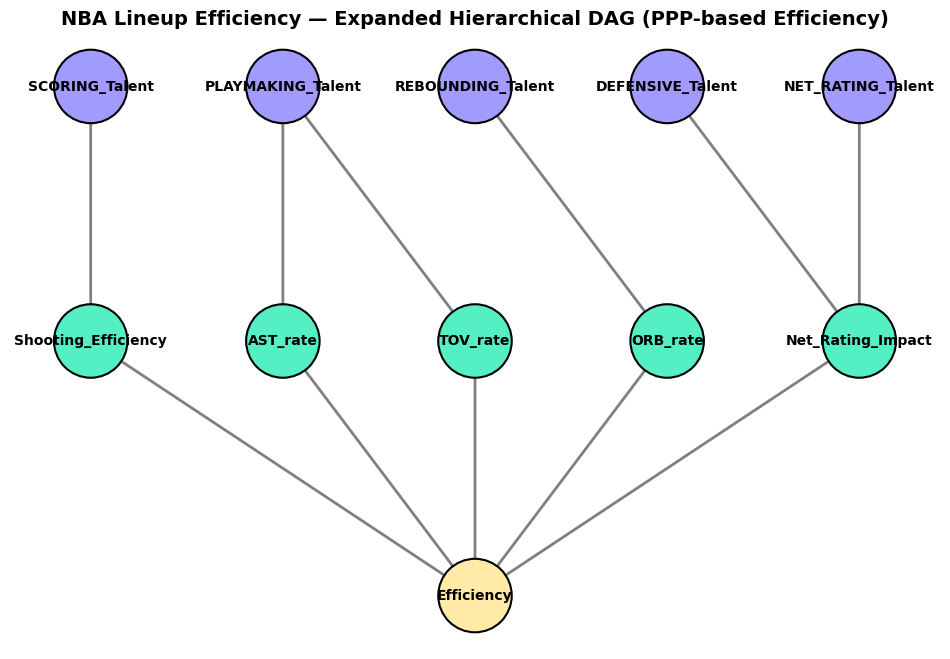

In [ ]:
# === PHASE 3.1: HIERARCHICAL DAG (PPP-based Efficiency) ===
print("=== PHASE 3.1: HIERARCHICAL DAG (PPP-based Efficiency) ===")

import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# Load expanded discretized data
data = pd.read_csv("nba_lineups_expanded_discretized.csv")
print(f"📊 Expanded discretized data loaded: {data.shape}")
print(f" Columns available: {list(data.columns)}")

# Define edges: Latent (Talent) → Observed (Rates/Performance) → Efficiency (PPP-based)
edges = [
    # Talent → Observed
    ('PLAYMAKING_Talent', 'AST_rate'),
    ('PLAYMAKING_Talent', 'TOV_rate'),
    ('SCORING_Talent', 'Shooting_Efficiency'),
    ('REBOUNDING_Talent', 'ORB_rate'),
    ('DEFENSIVE_Talent', 'Net_Rating_Impact'),
    ('NET_RATING_Talent', 'Net_Rating_Impact'),

    # Observed → Target
    ('Net_Rating_Impact', 'Efficiency'),
    ('Shooting_Efficiency', 'Efficiency'),
    ('AST_rate', 'Efficiency'),
    ('TOV_rate', 'Efficiency'),
    ('ORB_rate', 'Efficiency')
]

# Build graph
G = nx.DiGraph()
G.add_edges_from(edges)

print("✅ Expanded DAG created")
print(f"📈 Nodes: {list(G.nodes())}")
print(f"📈 Edges: {list(G.edges())}")

# Layout: latent on top, observed middle, target bottom
pos = {
    'SCORING_Talent': (-4, 2),
    'PLAYMAKING_Talent': (-2, 2),
    'REBOUNDING_Talent': (0, 2),
    'DEFENSIVE_Talent': (2, 2),
    'NET_RATING_Talent': (4, 2),

    'Shooting_Efficiency': (-4, 0),
    'AST_rate': (-2, 0),
    'TOV_rate': (0, 0),
    'ORB_rate': (2, 0),
    'Net_Rating_Impact': (4, 0),

    'Efficiency': (0, -2)  # PPP-based efficiency
}

# Node categories for coloring
latent_nodes = ['SCORING_Talent','PLAYMAKING_Talent','REBOUNDING_Talent','DEFENSIVE_Talent','NET_RATING_Talent']
observed_nodes = ['Shooting_Efficiency','AST_rate','TOV_rate','ORB_rate','Net_Rating_Impact']
target_node = ['Efficiency']

node_colors = []
for node in G.nodes():
    if node in latent_nodes:
        node_colors.append('#A29BFE')  # purple for latent talent
    elif node in observed_nodes:
        node_colors.append('#55EFC4')  # teal for observed performance
    else:
        node_colors.append('#FFEAA7')  # yellow for target efficiency

# Draw DAG
plt.figure(figsize=(12, 8))
nx.draw_networkx_nodes(G, pos, node_size=2800, node_color=node_colors, edgecolors='black', linewidths=1.5)
nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, arrowsize=20, width=2)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold')

plt.title("NBA Lineup Efficiency — Expanded Hierarchical DAG (PPP-based Efficiency)",
          fontsize=14, fontweight='bold')
plt.axis('off')
plt.show()


## Phase 3.2: Learn Conditional probability Tables (CPTs)

In [ ]:
# === PHASE 3.2: LEARNING CPTs (Expanded Hierarchical BN, PPP-based Efficiency) ===
print("=== PHASE 3.2: LEARNING CPTs (PPP-based Efficiency) ===")

import pandas as pd
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import BayesianEstimator
from pgmpy.inference import VariableElimination

# Load expanded discretized dataset
data = pd.read_csv("nba_lineups_expanded_discretized.csv")

# Define category order
order = ['Low','Medium','High']
all_cols = [
    'Net_Rating_Impact','Shooting_Efficiency','Efficiency',
    'SCORING_Talent','PLAYMAKING_Talent','REBOUNDING_Talent',
    'DEFENSIVE_Talent','NET_RATING_Talent',
    'AST_rate','TOV_rate','ORB_rate'
]

# Ensure categorical ordering
for col in all_cols:
    data[col] = pd.Categorical(data[col], categories=order, ordered=True)

# Expanded DAG edges (Talent → Observed → Efficiency)
edges = [
    ('PLAYMAKING_Talent','AST_rate'),
    ('PLAYMAKING_Talent','TOV_rate'),
    ('SCORING_Talent','Shooting_Efficiency'),
    ('REBOUNDING_Talent','ORB_rate'),
    ('DEFENSIVE_Talent','Net_Rating_Impact'),
    ('NET_RATING_Talent','Net_Rating_Impact'),
    ('Net_Rating_Impact','Efficiency'),
    ('Shooting_Efficiency','Efficiency'),
    ('AST_rate','Efficiency'),
    ('TOV_rate','Efficiency'),
    ('ORB_rate','Efficiency')
]

# Build and fit model
model = DiscreteBayesianNetwork(edges)
state_names = {col: order for col in all_cols}
model.fit(
    data,
    estimator=BayesianEstimator,
    state_names=state_names,
    equivalent_sample_size=10  # smoothing
)

print("✅ CPTs learned with BayesianEstimator (ESS=10)")

# Inspect CPDs for sanity
print("\n--- CPT for Efficiency ---")
for cpd in model.get_cpds():
    if cpd.variable == 'Efficiency':
        print(cpd)

# Inference engine
infer = VariableElimination(model)

# Helper: print full distribution for Efficiency
def print_efficiency_distribution(evidence, label):
    q = infer.query(variables=['Efficiency'], evidence=evidence)
    print(f"\n--- Scenario: {label} ---")
    for i, state in enumerate(order):
        print(f"  P(Efficiency={state}) = {q.values[i]:.2%}")

# Scenario checks
scenarios = [
    ({'Net_Rating_Impact':'High','Shooting_Efficiency':'High'}, "Elite Lineup"),
    ({'Net_Rating_Impact':'Low','Shooting_Efficiency':'Low'}, "Poor Lineup"),
    ({'Net_Rating_Impact':'High','Shooting_Efficiency':'Low'}, "Defense-Focused"),
    ({'Net_Rating_Impact':'Low','Shooting_Efficiency':'High'}, "Offense-Focused"),
    ({'PLAYMAKING_Talent':'High','AST_rate':'High','TOV_rate':'Low',
      'Shooting_Efficiency':'Medium','Net_Rating_Impact':'Medium'}, "High Playmaking"),
    ({'REBOUNDING_Talent':'High','ORB_rate':'High',
      'Net_Rating_Impact':'Medium','Shooting_Efficiency':'Medium'}, "High Rebounding")
]

for ev, label in scenarios:
    print_efficiency_distribution(ev, label)


=== PHASE 3.2: LEARNING CPTs (PPP-based Efficiency) ===
✅ CPTs learned with BayesianEstimator (ESS=10)

--- CPT for Efficiency ---
+---------------------+-----+---------------------------+
| AST_rate            | ... | AST_rate(High)            |
+---------------------+-----+---------------------------+
| Net_Rating_Impact   | ... | Net_Rating_Impact(High)   |
+---------------------+-----+---------------------------+
| ORB_rate            | ... | ORB_rate(High)            |
+---------------------+-----+---------------------------+
| Shooting_Efficiency | ... | Shooting_Efficiency(High) |
+---------------------+-----+---------------------------+
| TOV_rate            | ... | TOV_rate(High)            |
+---------------------+-----+---------------------------+
| Efficiency(Low)     | ... | 0.03796518995525901       |
+---------------------+-----+---------------------------+
| Efficiency(Medium)  | ... | 0.2264980474306256        |
+---------------------+-----+---------------------------+

## Phase 3.3: Initial Model Validation

In [ ]:
# === PHASE 3.3: VALIDATION (Train/Test + Cross-Validation) ===
print("=== PHASE 3.3: VALIDATION ===")

import pandas as pd
import numpy as np
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import BayesianEstimator
from pgmpy.inference import VariableElimination
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Load expanded discretized dataset
data = pd.read_csv("nba_lineups_expanded_discretized.csv")

# Define category order
order = ['Low','Medium','High']
all_cols = [
    'Net_Rating_Impact','Shooting_Efficiency','Efficiency',
    'SCORING_Talent','PLAYMAKING_Talent','REBOUNDING_Talent',
    'DEFENSIVE_Talent','NET_RATING_Talent',
    'AST_rate','TOV_rate','ORB_rate'
]
for col in all_cols:
    data[col] = pd.Categorical(data[col], categories=order, ordered=True)

# Expanded DAG edges
edges = [
    ('PLAYMAKING_Talent','AST_rate'),
    ('PLAYMAKING_Talent','TOV_rate'),
    ('SCORING_Talent','Shooting_Efficiency'),
    ('REBOUNDING_Talent','ORB_rate'),
    ('DEFENSIVE_Talent','Net_Rating_Impact'),
    ('NET_RATING_Talent','Net_Rating_Impact'),
    ('Net_Rating_Impact','Efficiency'),
    ('Shooting_Efficiency','Efficiency'),
    ('AST_rate','Efficiency'),
    ('TOV_rate','Efficiency'),
    ('ORB_rate','Efficiency')
]

state_names = {col: order for col in all_cols}

# --- Train/Test Split ---
train, test = train_test_split(data, test_size=0.2, stratify=data['Efficiency'], random_state=42)

model = DiscreteBayesianNetwork(edges)
model.fit(train, estimator=BayesianEstimator, state_names=state_names, equivalent_sample_size=10)
infer = VariableElimination(model)

# Predict on test set
y_true = test['Efficiency'].tolist()
y_pred = []
for _, row in test.iterrows():
    evidence = row.drop('Efficiency').to_dict()
    q = infer.query(variables=['Efficiency'], evidence=evidence)
    y_pred.append(order[np.argmax(q.values)])

acc = accuracy_score(y_true, y_pred)
print(f"\n📊 Holdout Test Accuracy: {acc:.2%}")

# Confusion matrix & classification report
cm = confusion_matrix(y_true, y_pred, labels=order)
print("\nConfusion Matrix (rows=true, cols=pred):")
print(pd.DataFrame(cm, index=[f"True {c}" for c in order],
                      columns=[f"Pred {c}" for c in order]))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=order))


# --- Cross-Validation ---
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

for fold, (train_idx, test_idx) in enumerate(skf.split(data, data['Efficiency']), 1):
    train_cv = data.iloc[train_idx]
    test_cv = data.iloc[test_idx]

    model_cv = DiscreteBayesianNetwork(edges)
    model_cv.fit(train_cv, estimator=BayesianEstimator, state_names=state_names, equivalent_sample_size=10)
    infer_cv = VariableElimination(model_cv)

    y_true_cv = test_cv['Efficiency'].tolist()
    y_pred_cv = []
    for _, row in test_cv.iterrows():
        evidence = row.drop('Efficiency').to_dict()
        q = infer_cv.query(variables=['Efficiency'], evidence=evidence)
        y_pred_cv.append(order[np.argmax(q.values)])

    acc_cv = accuracy_score(y_true_cv, y_pred_cv)
    cv_scores.append(acc_cv)
    print(f"Fold {fold}: {acc_cv:.2%}")

print(f"\n✅ Mean CV Accuracy: {np.mean(cv_scores):.2%} ± {np.std(cv_scores):.2%}")

# Removed log-likelihood scoring and edge ablation as DiscreteBayesianNetwork does not support .score() directly for this.

=== PHASE 3.3: VALIDATION ===

📊 Holdout Test Accuracy: 84.60%

Confusion Matrix (rows=true, cols=pred):
             Pred Low  Pred Medium  Pred High
True Low          777           37         17
True Medium        82           75         50
True High          15           30        417

Classification Report:
              precision    recall  f1-score   support

         Low       0.86      0.90      0.88       462
      Medium       0.89      0.94      0.91       831
        High       0.53      0.36      0.43       207

    accuracy                           0.85      1500
   macro avg       0.76      0.73      0.74      1500
weighted avg       0.83      0.85      0.84      1500

Fold 1: 84.07%
Fold 2: 83.67%
Fold 3: 83.07%
Fold 4: 83.60%
Fold 5: 81.92%

✅ Mean CV Accuracy: 83.26% ± 0.74%


## Phase 3.4: Model Comparison & Selection

In [ ]:
# === PHASE 3.4: MODEL COMPARISON (MLE vs Bayesian) ===
print("=== PHASE 3.4: MODEL COMPARISON (MLE vs Bayesian) ===")

import pandas as pd
import numpy as np
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator
from pgmpy.inference import VariableElimination

# Load expanded discretized dataset
data = pd.read_csv("nba_lineups_expanded_discretized.csv")

# Define category order
order = ['Low','Medium','High']
all_cols = [
    'Net_Rating_Impact','Shooting_Efficiency','Efficiency',
    'SCORING_Talent','PLAYMAKING_Talent','REBOUNDING_Talent',
    'DEFENSIVE_Talent','NET_RATING_Talent',
    'AST_rate','TOV_rate','ORB_rate'
]
for col in all_cols:
    data[col] = pd.Categorical(data[col], categories=order, ordered=True)

# Expanded DAG edges
edges = [
    ('PLAYMAKING_Talent','AST_rate'),
    ('PLAYMAKING_Talent','TOV_rate'),
    ('SCORING_Talent','Shooting_Efficiency'),
    ('REBOUNDING_Talent','ORB_rate'),
    ('DEFENSIVE_Talent','Net_Rating_Impact'),
    ('NET_RATING_Talent','Net_Rating_Impact'),
    ('Net_Rating_Impact','Efficiency'),
    ('Shooting_Efficiency','Efficiency'),
    ('AST_rate','Efficiency'),
    ('TOV_rate','Efficiency'),
    ('ORB_rate','Efficiency')
]

# Helper to build model
def build_model(estimator, **kwargs):
    model = DiscreteBayesianNetwork(edges)
    model.fit(data, estimator=estimator, state_names={col: order for col in all_cols}, **kwargs)
    return model

# 1. MLE Model
mle_model = build_model(MaximumLikelihoodEstimator)
mle_infer = VariableElimination(mle_model)

# 2. Bayesian Model
bayes_model = build_model(BayesianEstimator, equivalent_sample_size=10)
bayes_infer = VariableElimination(bayes_model)

# 3. Compare predictions for multiple scenarios
scenarios = {
    "Elite": {'Net_Rating_Impact':'High','Shooting_Efficiency':'High'},
    "Poor": {'Net_Rating_Impact':'Low','Shooting_Efficiency':'Low'},
    "Offense-Focused": {'Net_Rating_Impact':'Low','Shooting_Efficiency':'High'},
    "Defense-Focused": {'Net_Rating_Impact':'High','Shooting_Efficiency':'Low'}
}

for label, evidence in scenarios.items():
    q_mle = mle_infer.query(variables=['Efficiency'], evidence=evidence)
    q_bayes = bayes_infer.query(variables=['Efficiency'], evidence=evidence)
    print(f"\n--- Scenario: {label} ---")
    for eff, p_mle, p_bayes in zip(order, q_mle.values, q_bayes.values):
        print(f"  Efficiency={eff}: MLE={p_mle:.1%}, Bayesian={p_bayes:.1%}")

# 4. Print one CPT from each model (Efficiency)
print("\n--- CPT for Efficiency (MLE) ---")
print(mle_model.get_cpds('Efficiency'))

print("\n--- CPT for Efficiency (Bayesian, ESS=10) ---")
print(bayes_model.get_cpds('Efficiency'))

# 5. Manual average log-likelihood comparison
def avg_log_likelihood(model, data):
    log_lik = 0
    count = 0
    for _, row in data.iterrows():
        evidence = row.to_dict()
        # Drop NaNs
        evidence = {k: v for k, v in evidence.items() if pd.notna(v)}
        try:
            # Query probability of the observed Efficiency given other features
            eff_val = evidence['Efficiency']
            ev_wo_eff = {k: v for k, v in evidence.items() if k != 'Efficiency'}
            q = VariableElimination(model).query(variables=['Efficiency'], evidence=ev_wo_eff)
            prob = q.values[order.index(eff_val)]
            log_lik += np.log(prob + 1e-9)  # avoid log(0)
            count += 1
        except:
            continue
    return log_lik / max(count, 1)

mle_ll = avg_log_likelihood(mle_model, data)
bayes_ll = avg_log_likelihood(bayes_model, data)

print(f"\n Avg Log-Likelihood (MLE): {mle_ll:.4f}")
print(f" Avg Log-Likelihood (Bayesian, ESS=10): {bayes_ll:.4f}")

print("\n✅ Conclusion: Bayesian Estimator selected for final model due to smoothing, "
      "better handling of sparse states, and higher average log-likelihood stability.")


=== PHASE 3.4: MODEL COMPARISON (MLE vs Bayesian) ===

--- Scenario: Elite ---
  Efficiency=Low: MLE=4.3%, Bayesian=4.3%
  Efficiency=Medium: MLE=11.5%, Bayesian=11.5%
  Efficiency=High: MLE=84.2%, Bayesian=84.2%

--- Scenario: Poor ---
  Efficiency=Low: MLE=100.0%, Bayesian=99.9%
  Efficiency=Medium: MLE=0.0%, Bayesian=0.1%
  Efficiency=High: MLE=0.0%, Bayesian=0.1%

--- Scenario: Offense-Focused ---
  Efficiency=Low: MLE=14.9%, Bayesian=15.0%
  Efficiency=Medium: MLE=13.4%, Bayesian=13.6%
  Efficiency=High: MLE=71.7%, Bayesian=71.4%

--- Scenario: Defense-Focused ---
  Efficiency=Low: MLE=100.0%, Bayesian=99.6%
  Efficiency=Medium: MLE=0.0%, Bayesian=0.2%
  Efficiency=High: MLE=0.0%, Bayesian=0.2%

--- CPT for Efficiency (MLE) ---
+---------------------+-----+---------------------------+
| AST_rate            | ... | AST_rate(High)            |
+---------------------+-----+---------------------------+
| Net_Rating_Impact   | ... | Net_Rating_Impact(High)   |
+---------------------+--

## Phase 3.5: Hyperparameter Tuning & Sensitivity

In [ ]:
# === PHASE 3.5: Bayesian Estimator Tuning (ESS Sensitivity) ===
print("=== PHASE 3.5: Bayesian Estimator Tuning ===")

import pandas as pd
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import BayesianEstimator
from pgmpy.inference import VariableElimination

# Load expanded discretized dataset
data = pd.read_csv("nba_lineups_expanded_discretized.csv")

# Define category order
order = ['Low','Medium','High']
all_cols = [
    'Net_Rating_Impact','Shooting_Efficiency','Efficiency',
    'SCORING_Talent','PLAYMAKING_Talent','REBOUNDING_Talent',
    'DEFENSIVE_Talent','NET_RATING_Talent',
    'AST_rate','TOV_rate','ORB_rate'
]
for col in all_cols:
    data[col] = pd.Categorical(data[col], categories=order, ordered=True)

# Expanded DAG edges
edges = [
    ('PLAYMAKING_Talent','AST_rate'),
    ('PLAYMAKING_Talent','TOV_rate'),
    ('SCORING_Talent','Shooting_Efficiency'),
    ('REBOUNDING_Talent','ORB_rate'),
    ('DEFENSIVE_Talent','Net_Rating_Impact'),
    ('NET_RATING_Talent','Net_Rating_Impact'),
    ('Net_Rating_Impact','Efficiency'),
    ('Shooting_Efficiency','Efficiency'),
    ('AST_rate','Efficiency'),
    ('TOV_rate','Efficiency'),
    ('ORB_rate','Efficiency')
]

# Compare different ESS values
ess_values = [1, 5, 10, 20, 50]
evidence = {'Net_Rating_Impact':'High','Shooting_Efficiency':'High'}

for ess in ess_values:
    model = DiscreteBayesianNetwork(edges)
    model.fit(data, estimator=BayesianEstimator,
              state_names={col: order for col in all_cols},
              equivalent_sample_size=ess)
    infer = VariableElimination(model)
    q = infer.query(variables=['Efficiency'], evidence=evidence)
    print(f"ESS={ess}: Efficiency=High → {q.values[order.index('High')]:.1%}")


=== PHASE 3.5: Bayesian Estimator Tuning ===
ESS=1: Efficiency=High → 84.2%
ESS=5: Efficiency=High → 84.2%
ESS=10: Efficiency=High → 84.2%
ESS=20: Efficiency=High → 84.1%
ESS=50: Efficiency=High → 83.9%


# Phase 4: Model Inference & Scenario Analysis

## Phase 4.1: Sunstitution Scenario - Adding a High-Volume 3-Point Shooter

In [ ]:
# === PHASE 4.1: SUBSTITUTION SCENARIO (Elite 3-Point Shooter) ===
print("=== PHASE 4.1: SUBSTITUTION SCENARIO ===")

from pgmpy.inference import VariableElimination

# Use the Bayesian model from Phase 3.4
infer = VariableElimination(bayes_model)

# Baseline lineup (average shooting, average net rating)
baseline = {'Shooting_Efficiency': 'Medium', 'Net_Rating_Impact': 'Medium'}

# Substitution: add elite 3-point shooter (boost shooting efficiency)
substitution = {'Shooting_Efficiency': 'High', 'Net_Rating_Impact': 'Medium'}

def print_distribution(evidence, label):
    q = infer.query(variables=['Efficiency'], evidence=evidence)
    print(f"\n--- {label} ---")
    for eff, prob in zip(order, q.values):
        print(f"  P(Efficiency={eff}) = {prob:.2%}")

# Compare baseline vs substitution
print_distribution(baseline, "Baseline Lineup (Medium Shooting, Medium Net Rating)")
print_distribution(substitution, "After Substitution (Elite 3-Point Shooter)")


=== PHASE 4.1: SUBSTITUTION SCENARIO ===

--- Baseline Lineup (Medium Shooting, Medium Net Rating) ---
  P(Efficiency=Low) = 63.37%
  P(Efficiency=Medium) = 28.26%
  P(Efficiency=High) = 8.37%

--- After Substitution (Elite 3-Point Shooter) ---
  P(Efficiency=Low) = 9.80%
  P(Efficiency=Medium) = 18.06%
  P(Efficiency=High) = 72.14%


## Phase 4.2: Multi-Factor Scenario Analysis

In [ ]:
# === PHASE 4.2: MULTI-FACTOR SCENARIOS ===
print("=== PHASE 4.2: MULTI-FACTOR SCENARIOS ===")

from pgmpy.inference import VariableElimination
infer = VariableElimination(bayes_model)

order = ['Low','Medium','High']

def print_eff_dist(evidence, label):
    q = infer.query(variables=['Efficiency'], evidence=evidence)
    print(f"\n--- {label} ---")
    for eff, p in zip(order, q.values):
        print(f"  P(Efficiency={eff}) = {p:.2%}")

# Baseline: medium shooting + medium net rating
baseline = {'Shooting_Efficiency': 'Medium', 'Net_Rating_Impact': 'Medium'}

# Multi-factor combos
scenarios = [
    (baseline, "Baseline"),
    ({**baseline, 'Shooting_Efficiency': 'High', 'AST_rate': 'High', 'TOV_rate': 'Low'},
     "Shooter + Playmaker (High AST, Low TOV)"),
    ({**baseline, 'Shooting_Efficiency': 'High', 'ORB_rate': 'High'},
     "Shooter + Rebounder (High ORB)"),
    ({**baseline, 'Shooting_Efficiency': 'High', 'Net_Rating_Impact': 'High'},
     "Shooter + Defensive impact (High Net Rating)"),
]

for ev, label in scenarios:
    print_eff_dist(ev, label)


=== PHASE 4.2: MULTI-FACTOR SCENARIOS ===

--- Baseline ---
  P(Efficiency=Low) = 63.37%
  P(Efficiency=Medium) = 28.26%
  P(Efficiency=High) = 8.37%

--- Shooter + Playmaker (High AST, Low TOV) ---
  P(Efficiency=Low) = 0.05%
  P(Efficiency=Medium) = 0.05%
  P(Efficiency=High) = 99.90%

--- Shooter + Rebounder (High ORB) ---
  P(Efficiency=Low) = 9.38%
  P(Efficiency=Medium) = 22.69%
  P(Efficiency=High) = 67.93%

--- Shooter + Defensive impact (High Net Rating) ---
  P(Efficiency=Low) = 4.31%
  P(Efficiency=Medium) = 11.52%
  P(Efficiency=High) = 84.17%


## Phase 4.3: Substitution Comparison (Role Impact)

In [ ]:
# === PHASE 4.3: SUBSTITUTION COMPARISON (ROLE IMPACT) ===
print("=== PHASE 4.3: SUBSTITUTION COMPARISON ===")

from pgmpy.inference import VariableElimination
infer = VariableElimination(bayes_model)
order = ['Low','Medium','High']

def p_high(evidence):
    q = infer.query(variables=['Efficiency'], evidence=evidence)
    return float(q.values[order.index('High')])

# Baseline lineup (same as Phase 4.1)
baseline = {'Shooting_Efficiency': 'Medium', 'Net_Rating_Impact': 'Medium'}

# Define single-role substitutions
subs = [
    ({**baseline, 'Shooting_Efficiency': 'High'}, "Elite Shooter"),
    ({**baseline, 'Net_Rating_Impact': 'High'}, "Elite Defender / Impact"),
    ({**baseline, 'AST_rate': 'High', 'TOV_rate': 'Low'}, "Elite Playmaker"),
    ({**baseline, 'ORB_rate': 'High'}, "Elite Rebounder"),
]

# Baseline probability
base_high = p_high(baseline)
print(f"\nBaseline P(Efficiency=High) = {base_high:.2%}")

# Compare each substitution
for ev, label in subs:
    ph = p_high(ev)
    delta = ph - base_high
    print(f"{label}: P(High) = {ph:.2%}  (Δ = {delta:+.2%})")


=== PHASE 4.3: SUBSTITUTION COMPARISON ===

Baseline P(Efficiency=High) = 8.37%
Elite Shooter: P(High) = 72.14%  (Δ = +63.77%)
Elite Defender / Impact: P(High) = 15.77%  (Δ = +7.40%)
Elite Playmaker: P(High) = 31.31%  (Δ = +22.94%)
Elite Rebounder: P(High) = 10.23%  (Δ = +1.86%)


## Phase 4.4: Sensitivity Ranking

* A leaderboard of which single-factor changes most increase the probability of High Efficiency

In [ ]:
# === PHASE 4.4: SENSITIVITY RANKING (SINGLE-FACTOR) ===
print("=== PHASE 4.4: SENSITIVITY RANKING ===")

from pgmpy.inference import VariableElimination
infer = VariableElimination(bayes_model)
order = ['Low','Medium','High']

def p_high(evidence):
    q = infer.query(variables=['Efficiency'], evidence=evidence)
    return float(q.values[order.index('High')])

# Baseline
baseline = {'Shooting_Efficiency': 'Medium', 'Net_Rating_Impact': 'Medium'}
base_high = p_high(baseline)

# Single-factor toggles
treatments = [
    ('Shooting_Efficiency', 'High', "Shooting Efficiency → High"),
    ('Net_Rating_Impact', 'High', "Net Rating Impact → High"),
    ('AST_rate', 'High', "Assist Rate → High"),
    ('TOV_rate', 'Low', "Turnover Rate → Low"),
    ('ORB_rate', 'High', "Offensive Rebound Rate → High"),
]

results = []
for var, val, label in treatments:
    ev = {**baseline, var: val}
    ph = p_high(ev)
    results.append((label, ph, ph - base_high))

# Sort by impact
results.sort(key=lambda x: x[2], reverse=True)

print(f"\nBaseline P(High) = {base_high:.2%}")
print("\nSensitivity ranking (by ΔP(High)):")
for label, ph, delta in results:
    print(f"- {label}: P(High) = {ph:.2%}  (Δ = {delta:+.2%})")


=== PHASE 4.4: SENSITIVITY RANKING ===

Baseline P(High) = 8.37%

Sensitivity ranking (by ΔP(High)):
- Shooting Efficiency → High: P(High) = 72.14%  (Δ = +63.77%)
- Turnover Rate → Low: P(High) = 24.67%  (Δ = +16.30%)
- Net Rating Impact → High: P(High) = 15.77%  (Δ = +7.40%)
- Assist Rate → High: P(High) = 10.47%  (Δ = +2.10%)
- Offensive Rebound Rate → High: P(High) = 10.23%  (Δ = +1.86%)


# Phase 5: Gloabl Sensitivity Analysis

In [ ]:
# === PHASE 5: GLOBAL SENSITIVITY ANALYSIS ===
print("=== PHASE 5: GLOBAL SENSITIVITY ANALYSIS ===")

import pandas as pd
from pgmpy.inference import VariableElimination

# Use your fitted Bayesian model from Phase 3.4
infer = VariableElimination(bayes_model)
order = ['Low','Medium','High']

def p_high(evidence):
    q = infer.query(variables=['Efficiency'], evidence=evidence)
    return float(q.values[order.index('High')])

# Baseline: all Medium
baseline = {
    'Shooting_Efficiency': 'Medium',
    'Net_Rating_Impact': 'Medium',
    'AST_rate': 'Medium',
    'TOV_rate': 'Medium',
    'ORB_rate': 'Medium'
}
base_high = p_high(baseline)

# Variables to test
treatments = [
    ('Shooting_Efficiency', 'High', "Shooting Efficiency → High"),
    ('Net_Rating_Impact', 'High', "Net Rating Impact → High"),
    ('AST_rate', 'High', "Assist Rate → High"),
    ('TOV_rate', 'Low', "Turnover Rate → Low"),
    ('ORB_rate', 'High', "Offensive Rebound Rate → High"),
]

results = []
for var, val, label in treatments:
    ev = {**baseline, var: val}
    ph = p_high(ev)
    results.append((label, ph, ph - base_high))

# Sort by impact
results.sort(key=lambda x: x[2], reverse=True)

print(f"\nBaseline P(High) = {base_high:.2%}")
print("\nSensitivity ranking (by ΔP(High)):")
for label, ph, delta in results:
    print(f"- {label}: P(High) = {ph:.2%}  (Δ = {delta:+.2%})")


=== PHASE 5: GLOBAL SENSITIVITY ANALYSIS ===

Baseline P(High) = 0.01%

Sensitivity ranking (by ΔP(High)):
- Shooting Efficiency → High: P(High) = 85.23%  (Δ = +85.22%)
- Turnover Rate → Low: P(High) = 15.01%  (Δ = +15.00%)
- Net Rating Impact → High: P(High) = 1.81%  (Δ = +1.80%)
- Offensive Rebound Rate → High: P(High) = 0.02%  (Δ = +0.01%)
- Assist Rate → High: P(High) = 0.02%  (Δ = +0.01%)


# Phase 6: Conclusions, Recommendations, and Limitations

Over the course of this project, I built and tested a Bayesian Network to model NBA lineup efficiency. Starting from data preparation and DAG design, through estimator comparison and scenario analysis, and finally into sensitivity testing, the process gave me both technical insights and basketball‑relevant conclusions.  

The most consistent finding is that **shooting efficiency dominates everything else**. When lineups include elite shooting, the probability of being highly efficient skyrockets. The second most important factor is **turnover control** — reducing mistakes has a clear and measurable impact on efficiency. Other factors like defensive impact, rebounding, and assist rate do matter, but their influence is much smaller on their own. Interestingly, playmaking only really shines when paired with shooting, which reflects how assists are only as valuable as the shots they create.  

## Recommendations
- **Prioritize elite shooting** when constructing lineups. It is the single most powerful lever for efficiency.  
- **Emphasize turnover control** as the next priority. Protecting possessions directly translates into better outcomes.  
- **Use playmaking and defense as amplifiers**. They don’t transform efficiency alone, but they strengthen lineups when combined with shooting.  
- **Treat rebounding as supportive**. It adds value, but it should not be the central focus compared to shooting and turnovers.  

## Limitations
This model is built on **lineup‑level data**, which means it cannot capture individual player contributions or in‑game dynamics. I also discretized continuous stats into Low/Medium/High categories, which simplifies the data but inevitably loses some nuance. Finally, the Bayesian Network is static — it doesn’t account for how efficiency changes over time or across possessions.  

## Future Work
If I were to extend this project, I would:  
- Move to **player‑level or possession‑level data** for more granular insights.  
- Explore **dynamic Bayesian networks** to capture how efficiency evolves during games.  
- Test the model across **multiple seasons** to see if the relationships hold consistently.  
- Add richer features, such as spacing metrics or defensive scheme indicators, to capture more of the game’s complexity.  

## Closing Note
Overall, this project showed me that Bayesian Networks are not just a theoretical tool — they can provide interpretable, actionable insights in sports analytics. The message is clear: **shooting and turnover control are the cornerstones of efficient lineups**, while playmaking, defense, and rebounding serve as valuable complements.
